In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

## Builder Functions

In [2]:
# Option 1: Normalize per protein across all fractions of a replicate to add up to 1
def normalize_byRow(df):
    df.fillna(0, inplace=True)
    normalized_array = df.to_numpy() / np.sum(df.to_numpy(), axis=1)[:, np.newaxis]
    normalized_df = pd.DataFrame(normalized_array, index=df.index, columns=df.columns)
    normalized_df.fillna(0, inplace=True) #div by 0 might intro NAs
    return normalized_df

# Option 2 normalize by z-score
def z_norm(df):
    df.fillna(0, inplace=True)
    df = df.apply(zscore, axis=1)
    return df

In [3]:
def intersect_networks(G1, G2, weight_mode='fixed', fixed_value=1):
    #receives two networks with the same node names, and returns a third network that only keeps the edges that are present in both
    #option to set all output node weights to either a fixed provided value, or use the average, maximum or, minimum of the overlapping edges in the two input networks
    G_common = nx.Graph()
    G_common.add_nodes_from(G1.nodes)
    
    edges_G1 = set(G1.edges())
    edges_G2 = set(G2.edges())
    common_edges = edges_G1 & edges_G2
    
    for u, v in common_edges:
        w1 = G1[u][v].get('weight', 1)
        w2 = G2[u][v].get('weight', 1)
        
        if weight_mode == 'average':
            weight = (w1 + w2) / 2
        elif weight_mode == 'max':
            weight = max(w1, w2)
        elif weight_mode == 'min':
            weight = min(w1, w2)
        else:  # 'fixed'
            weight = fixed_value
        
        G_common.add_edge(u, v, weight=weight)
    
    print(f"Edges in resulting network: {len(G_common.edges())}")
    print(f"Edges removed from G1: {len(edges_G1 - common_edges)}")
    print(f"Edges removed from G2: {len(edges_G2 - common_edges)}")
    
    return G_common


In [4]:
def build_network_from_matrix(mat, combine_replicates=False, corr_type='pearson', build_method='thres', cutoff=0.7):

    #NAs to 0, all to numeric
    mat=mat.apply(pd.to_numeric, errors='coerce')
    mat.fillna(0, inplace=True)
    ####alternatively comment above to keep as NAs

    #combine reps by taking average - probably not great as not all fracs have high concordance
    if combine_replicates:
        mat=combine_reps(mat)

    #calc corr
    corr=mat.T.corr(method=corr_type)
    np.fill_diagonal(corr.values, 0)

    #adjacency metric - diff approaches
    if build_method=='thres':
        corr[corr<= cutoff] = 0
    #elif build_method=='stack':
    #
    
    #create networkx obj
    net = nx.from_pandas_adjacency(corr)
    print(len(net.nodes), "nodes in the graph")
    print(len(net.edges), "edges in the graph")
    
    return net

def partition(net, res=1, weight=None): #following same format as interactions nb

    communities=nx.community.louvain_communities(net, resolution=res, weight=weight, seed=123)
    
    label=1
    for community in communities:
        for nod in community:
            net.nodes[nod]["community label"]="community "+str(label)
        label+=1
     
    community_dict=nx.get_node_attributes(net, 'community label')

    output=pd.DataFrame({"id":range(len(net.nodes)),
                        "xxx":list(net.nodes),
                        "prediction":list(community_dict.values())})
    return communities, output

In [5]:
#make a corr table per replicate
def subset_replicates(df, replicate_num):
    #subsets the pd.df to only include columns for one given replicate (replicate num)
    replicate_df = df.filter(like=f"repl{replicate_num}_")
    
    return replicate_df

## Other useful functions

In [6]:
def combine_reps(df):
    #want a df with a single columns per fraction (take average of reps), handle NA vals
    fractions=sorted(set(int(col.split('_')[1]) for col in df.columns))
    
    combined= pd.DataFrame()
    
    for fraction in fractions:
        rep1_col = f'repl1_{fraction}'
        rep2_col = f'repl2_{fraction}'
        
        if rep1_col in df.columns and rep2_col in df.columns:
            combined[f'fraction_{fraction}'] = df[[rep1_col, rep2_col]].mean(axis=1, skipna=True)
        elif rep1_col in df.columns:
            combined[f'fraction_{fraction}'] = df[rep1_col]
        elif rep2_col in df.columns:
            combined[f'fraction_{fraction}'] = df[rep2_col]
    
    return combined

In [7]:
def compute_fraction_correlations(df):
    #Computes the correlation between replicates for each fraction.
    correlation_values = []
    
    #unique fracs
    fraction_numbers = sorted(set(col.split('_')[1] for col in df.columns))
    
    for fraction in fraction_numbers:
        #find cols per frac
        repl1_col = f"repl1_{fraction}"
        repl2_col = f"repl2_{fraction}"
        
        #make sure both exist
        if repl1_col in df.columns and repl2_col in df.columns:
            #save corr to list
            correlation = df[repl1_col].corr(df[repl2_col])
            correlation_values.append(correlation)
    
    return correlation_values

In [8]:
def quick_hist(values, bins=30, title='Histogram of DataFrame Values'):
    mean_value = np.nanmean(values)  
    median_value = np.nanmedian(values)

    plt.figure(figsize=(8, 6))
    plt.hist(values, bins=bins, edgecolor='black', alpha=0.7, color='gold')

    plt.axvline(mean_value, color='blue', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
    plt.axvline(median_value, color='purple', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')
    
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend()
    plt.show()

## Basic build

In [9]:
file='./repl1_repl2_combined.tsv'
table=pd.read_table(file, index_col=0)

In [10]:
#per replicate
tableR1 = subset_replicates(table, 1)
tableR2 = subset_replicates(table, 2) 

print(tableR1.shape)
print(tableR2.shape)

(8178, 72)
(8178, 72)


In [11]:
##normalize by row
#tableR1_norm = normalize_byRow(tableR1)
#tableR2_norm = normalize_byRow(tableR2)

#OR by z-score
tableR1_norm = z_norm(tableR1)
tableR2_norm = z_norm(tableR2)

C:\Users\lhinojosa\AppData\Local\Temp\ipykernel_18948\3334669920.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)
C:\Users\lhinojosa\AppData\Local\Temp\ipykernel_18948\3334669920.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)


Text(74.44444444444444, 0.5, 'protein')

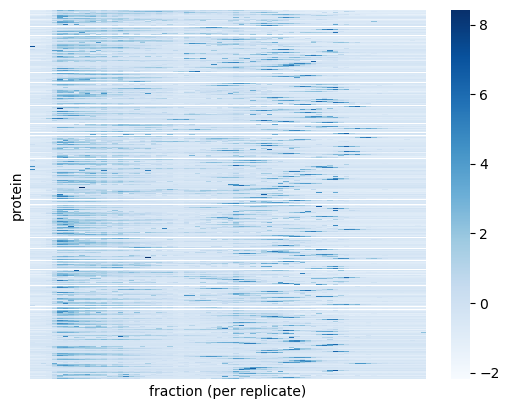

In [12]:
sns.heatmap(tableR1_norm, cmap=sns.color_palette("Blues", as_cmap=True),xticklabels=False, yticklabels=False)
plt.xlabel("fraction (per replicate)")
plt.ylabel("protein")

Text(74.44444444444444, 0.5, 'protein')

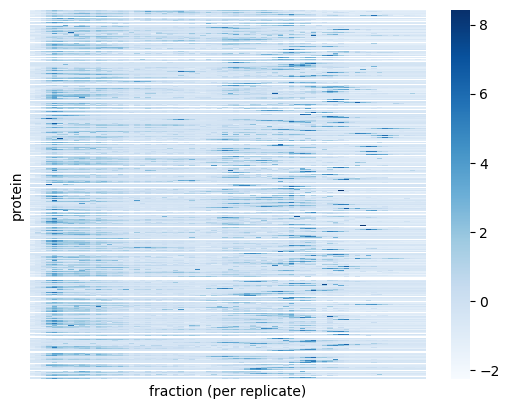

In [13]:
sns.heatmap(tableR2_norm, cmap=sns.color_palette("Blues", as_cmap=True),xticklabels=False, yticklabels=False)
plt.xlabel("fraction (per replicate)")
plt.ylabel("protein")

In [14]:
# build network per rep
cutoff=0.9
net1=build_network_from_matrix(mat=tableR1_norm, combine_replicates=False, corr_type='pearson', build_method='thres', cutoff=cutoff)
net2=build_network_from_matrix(mat=tableR2_norm, combine_replicates=False, corr_type='pearson', build_method='thres', cutoff=cutoff)
#combine into a single network, keeping mean value per entry
inter_net=intersect_networks(net1, net2, weight_mode='average')

8178 nodes in the graph
3562577 edges in the graph
8178 nodes in the graph
5902156 edges in the graph
Edges in resulting network: 482841
Edges removed from G1: 3079736
Edges removed from G2: 5419315


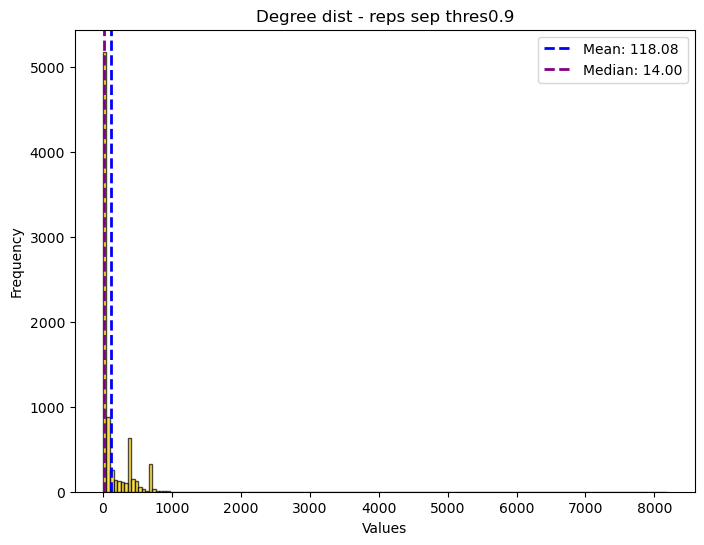

In [15]:
degrees=[d for n, d in inter_net.degree()]
quick_hist(degrees, bins=160, title='Degree dist - reps sep thres'+ str(cutoff))
#quick_hist([d for d in degrees if d!=max(degrees)], bins=140, title='Degree dist - reps sep thres ' + str(cutoff)) #remove single max outlier

In [16]:
print(max(degrees))

8177


## Basic Partition with louvain

In [36]:
res=200
#combined, out=partition(inter_net, res=res, weight='weight') #weighted
combined, out=partition(inter_net, res=res, weight=None) #unweighted
size_dist=[len(community) for community in combined]
len(combined)

4955

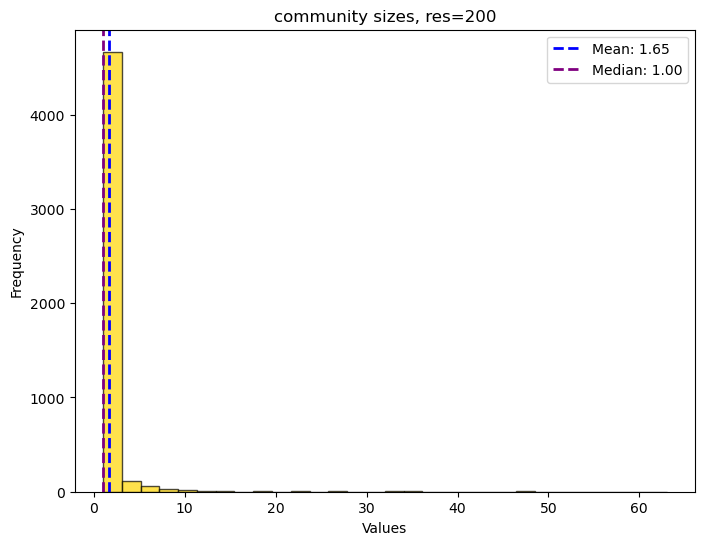

In [37]:
quick_hist(size_dist, title='community sizes, res='+str(res))

In [38]:
#discard communities with only one node - THIS WAS OUR LATEST SUBMISSION< BUT WITH BY_ROW NORMALIZATION
filtered=[]
for community in combined:
    if len(community)>1:
        filtered.append(community)

(array([576.,  47.,  13.,   9.,   6.,   6.,   4.,   4.,   2.,   3.]),
 array([ 2. ,  8.1, 14.2, 20.3, 26.4, 32.5, 38.6, 44.7, 50.8, 56.9, 63. ]),
 <BarContainer object of 10 artists>)

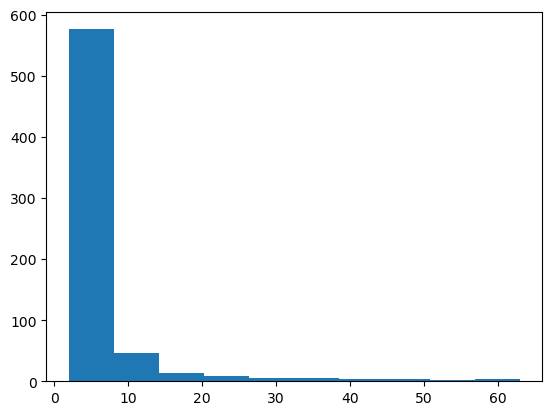

In [39]:
plt.hist(np.array([len(a) for a in filtered]))

## subset oneclust

In [42]:
#read one clust and remove rpots not in there
import csv

second_column = []

with open('onecluster.csv', 'r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for i, row in enumerate(reader):
        if len(row) >= 2 & i>0:  # Ensure there are at least two columns
            second_column.append(row[1])

#print(second_column)


In [44]:
with open('./net2_sep_louvainNormPerRow_cutoff0.9_res200_FILT2.csv', 'w') as outF:
    j=1
    header='id,xxx,prediction\n'
    #print(header)
    outF.write(header)
    for i, community in enumerate(filtered):
        for nod in community:
            if nod in second_column:
                line=str(j) +','+ nod +','+ 'community'+str(i) + '\n'
                #print(line)
                outF.write(line)
                j=j+1

## Test with HiDef

In [16]:
import ndex2
#import all listed packages
#import click
#import seaborn
#import tqdm
#import mygene
#import scipy
#import statsmodels
#import DDOT
import cdapsutil
from netcoloc import netprop_zscore, netprop, network_colocalization, validation
import netcoloc

In [17]:
G_ndex = ndex2.create_nice_cx_from_networkx(inter_net)

cd = cdapsutil.CommunityDetection()

In [18]:
G_hier = cd.run_community_detection(G_ndex, algorithm='hidefv1.1beta',arguments={'--maxres':'300'})

In [19]:
G_hier_net = G_hier.to_networkx(mode='default')

nodes = G_hier_net.nodes()

print('Number of nodes:', len(G_hier_net.nodes()))
print('\nNumber of edges:', len(G_hier_net.edges()))

Number of nodes: 604

Number of edges: 718


In [20]:
hier_df = pd.DataFrame.from_dict(dict(G_hier_net.nodes(data=True)), orient='index')
hier_df['system_ID']=hier_df.index.tolist()
hier_df['CD_MemberList_Size']=[int(x) for x in hier_df['CD_MemberList_Size'].tolist()]
hier_df['HiDeF_persistence']=[int(x) for x in hier_df['HiDeF_persistence'].tolist()]
#hier_df.head()

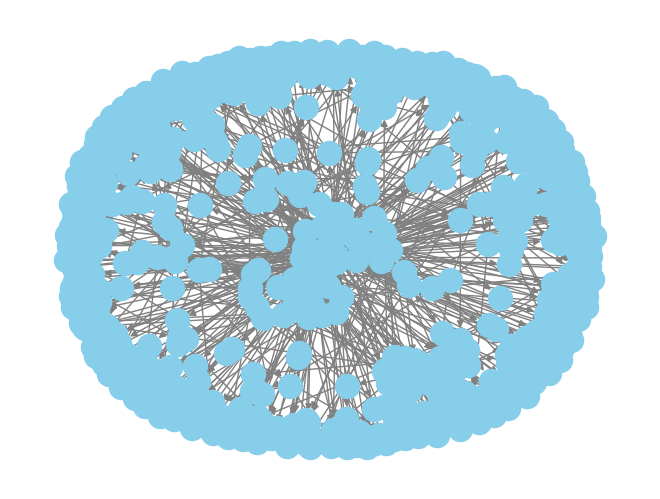

In [21]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G_hier_net, seed=42)
nx.draw(G_hier_net, pos, with_labels=False, node_color='skyblue', edge_color='gray')
plt.show()

(array([596.,   4.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([3.0000e+00, 8.2050e+02, 1.6380e+03, 2.4555e+03, 3.2730e+03,
        4.0905e+03, 4.9080e+03, 5.7255e+03, 6.5430e+03, 7.3605e+03,
        8.1780e+03]),
 <BarContainer object of 10 artists>)

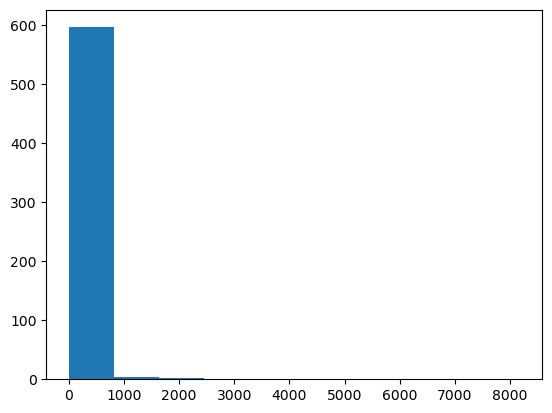

In [22]:
plt.hist(np.array( [ d for d in hier_df['CD_MemberList_Size'] if d>1]))

In [23]:
max(np.array(hier_df['CD_MemberList_Size']))

8178

In [24]:
communities_dict_hidef={}
for comm, info in G_hier_net.nodes(data=True):
    tmp=info['CD_MemberList'].split()
    communities_dict_hidef[comm]={'proteins':tmp,'size':len(tmp)}

In [25]:
[communities_dict_hidef[i]['size'] for i in range(len(communities_dict_hidef))]

[8178,
 4,
 230,
 219,
 4,
 4,
 187,
 158,
 4,
 4,
 123,
 121,
 109,
 82,
 4,
 4,
 43,
 41,
 30,
 26,
 20,
 20,
 18,
 18,
 15,
 15,
 14,
 14,
 13,
 12,
 12,
 11,
 11,
 11,
 11,
 10,
 10,
 10,
 10,
 9,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 9,
 6,
 6,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5102,
 1391,
 1097,
 417,
 4,
 5,
 165,
 157,
 5,
 9,
 5,
 9,
 8,
 8,
 8,
 17,
 16,
 5,
 16,
 16,
 15,
 67,
 15,
 5,
 4,
 7,
 7,
 4,
 13,
 7,
 4,
 7,
 11,
 10,
 2354,
 2074,
 4,
 5,
 6,
 6,
 5,
 4,
 5,
 4,
 7,
 4,
 903,
 11,
 10,
 4,
 9,
 148,
 125,
 4,
 94,
 4,
 4,
 8,
 14,
 4,
 4,
 4,
 7,
 4,
 41,
 7,
 4,
 11,
 11,
 10,
 1318,
 6,
 476,
 455,
 6,
 22,
 20,
 19,
 5,
 5,
 8,
 18,
 8,
 4,
 4,
 11,
 65,
 8,
 60,
 4,
 14,
 13,
 4,
 7,
 3,
 4,
 48,
 45,
 4,
 4,
 7,
 11,
 4,
 4,
 11,
 4,
 6,
 11,
 31,
 31,
 4,
 4,
 304,
 10,
 4,
 4,
 5,
 104,
 5,
 4,
 8,
 4,
 4,
 4,
 8,
 4,
 5,
 5,
 5,
 14,
 7,
 7,
 7,
 4,
 6,
 4,
 416,
 342,
 57,
 299,
 140,


In [ ]:
per_prot_belong={} #note that community is shorthand for node here - not the same as other cases
for comm, community_members in communities_dict_hidef.items():
    for protein in community_members['proteins']:
        per_prot_belong.setdefault(protein, []).append(comm)
per_prot_belong

{'93Z1TCF7Z': [0, 78, 113, 148],
 'GK4NHSDP7': [0, 78, 113, 148, 214],
 '0ITZRZH6P': [0, 3, 37, 79, 160, 300, 301, 311, 340, 564],
 '82F3XJCF7': [0, 3, 79, 300, 311, 340],
 'A1FWZNGR4': [0, 78, 93, 113, 145, 148, 150, 551],
 'XSXX8341V': [0, 78, 112, 124],
 'LK00FZEWG': [0, 80, 217, 291, 322, 379, 446],
 'O9UJ8ANLL': [0, 78, 112, 124],
 '1EG857RZ3': [0, 78, 112],
 '9H9ZLRRGR': [0, 79],
 'NWWTCQ52N': [0, 79],
 'C2UE1YHFI': [0, 78, 85, 317, 358, 384],
 '1RWRYQHPP': [0, 6, 309, 441],
 'K1GU34774': [0, 79],
 'JWRQZA9WD': [0, 12, 364, 365, 427, 519],
 'HOBDNHGZ2': [0, 6, 80, 216],
 'BDC0VZJZC': [0, 81, 246, 274, 319],
 'CWUD35RL3': [0, 78, 112],
 'BIFNQEWTS': [0, 78, 112],
 'M04H0ZPTF': [0, 78, 112, 124],
 '4O08MSQRN': [0, 80, 218, 342],
 'EDIB9Q3QO': [0, 78, 112],
 'YBJAB9T1Q': [0, 78, 112, 124],
 'INMRYCKA7': [0, 80, 217, 291, 322, 379, 446],
 'L263NWFI6': [0, 78, 85, 317, 358, 384],
 '8COIYEP5V': [0, 79],
 '48U97AOOL': [0, 79],
 'A2XCBOQNR': [0, 78, 112],
 'DQ1BI8IOW': [0, 7, 81, 247, 24

(array([ 882., 1751., 1717.,  891., 1292., 1241.,  256.,  116.,   28.,
           4.]),
 array([ 1. ,  2.2,  3.4,  4.6,  5.8,  7. ,  8.2,  9.4, 10.6, 11.8, 13. ]),
 <BarContainer object of 10 artists>)

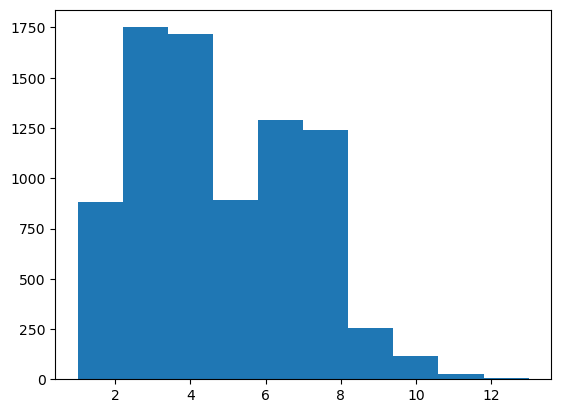

In [27]:
plt.hist(np.array([len(comms) for prot, comms in per_prot_belong.items()]))

### Jaccard approach

In [45]:
all_prots = list(per_prot_belong.keys())
n = len(all_prots)

empty_array = np.empty((n, n))
new_adj = pd.DataFrame(empty_array, index=all_prots, columns=all_prots)

for i, prot1 in enumerate(all_prots):
    a = per_prot_belong[prot1]
    for j in range(i, n):
        prot2 = all_prots[j]
        b = per_prot_belong[prot2]
        
        if prot1 == prot2:
            w = 0
        else:
            #union = set_a | set_b
            union = len(set(a+b))
            #intersection = set_a & set_b
            intersection = len(set([c for c in a if c in b]))
            #w = len(intersection) / len(union) if len(union) > 0 else 0.0
            w= intersection / union if union > 0 else 0

        #symmetry
        new_adj.loc[prot1, prot2] = w
        new_adj.loc[prot2, prot1] = w
        #print(w)

print(new_adj.shape)

(8178, 8178)


In [33]:
n

8178

(array([[3.680e+02, 1.878e+03, 1.310e+03, ..., 2.700e+01, 3.230e+02,
         1.220e+02],
        [7.730e+02, 2.304e+03, 1.653e+03, ..., 7.000e+01, 2.560e+02,
         9.500e+01],
        [6.691e+03, 5.280e+02, 7.790e+02, ..., 1.000e+00, 2.000e+00,
         4.000e+00],
        ...,
        [1.670e+02, 1.968e+03, 2.537e+03, ..., 9.440e+02, 0.000e+00,
         1.380e+03],
        [7.020e+02, 5.548e+03, 1.706e+03, ..., 1.500e+01, 0.000e+00,
         5.600e+01],
        [7.730e+02, 2.304e+03, 1.654e+03, ..., 1.900e+01, 2.000e+02,
         1.720e+02]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 8178 BarContainer objects>)

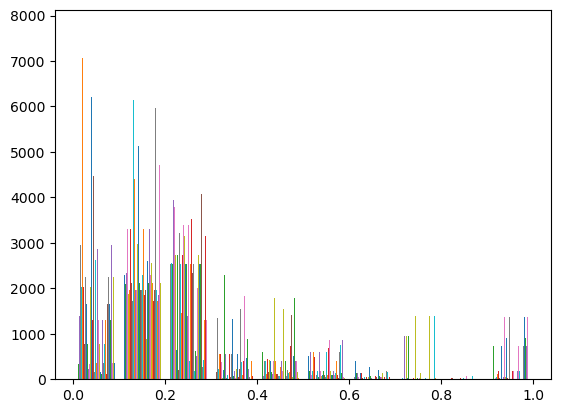

In [49]:
plt.hist(new_adj.values)

In [58]:
new_adj.to_csv('jaccardFromHiDef.tsv', sep='\t')

In [46]:
#make a network from this new adjacency matrix
G_jaccard = nx.from_pandas_adjacency(new_adj)
len(G_jaccard.nodes)

8178

In [60]:
list(G_jaccard.edges(data=True))[0]

('93Z1TCF7Z', 'GK4NHSDP7', {'weight': 0.8})

In [87]:
#remove edges with weight under 0.3
edges_to_remove = [(u, v) for u, v, weight in G_jaccard.edges(data='weight') if weight < 0.5]
G_jaccard.remove_edges_from(edges_to_remove)

# Check the remaining edges
print("Remaining edges:", len(G_jaccard.edges(data=True)))

Remaining edges: 4471856


In [88]:
#remove nodes with degree 0
isolated_nodes = [node for node, degree in G_jaccard.degree() if degree == 0]

# Remove them from the graph
G_jaccard.remove_nodes_from(isolated_nodes)
len(G_jaccard.nodes)

8178

In [78]:
#find communities - quick louvain
res=10
#from_jacc, out=partition(inter_net, res=res, weight='weight') #weighted
from_jacc, out=partition(G_jaccard, res=res, weight=None) #unweighted
size_dist=[len(community) for community in from_jacc]
len(from_jacc)

3898

(array([3.878e+03, 9.000e+00, 1.000e+00, 4.000e+00, 0.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([  1. ,  53.7, 106.4, 159.1, 211.8, 264.5, 317.2, 369.9, 422.6,
        475.3, 528. ]),
 <BarContainer object of 10 artists>)

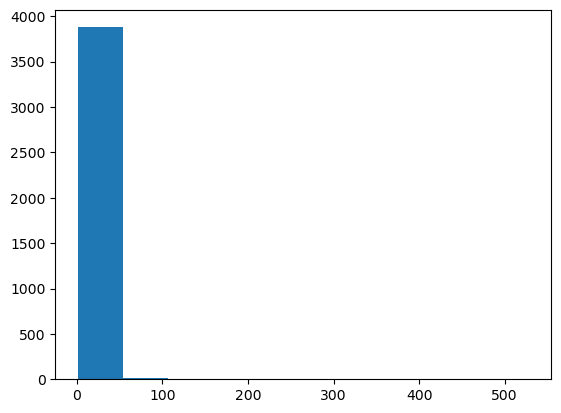

In [79]:
plt.hist(size_dist)

(array([194.,   9.,   1.,   4.,   0.,   3.,   1.,   1.,   0.,   1.]),
 array([  2. ,  54.6, 107.2, 159.8, 212.4, 265. , 317.6, 370.2, 422.8,
        475.4, 528. ]),
 <BarContainer object of 10 artists>)

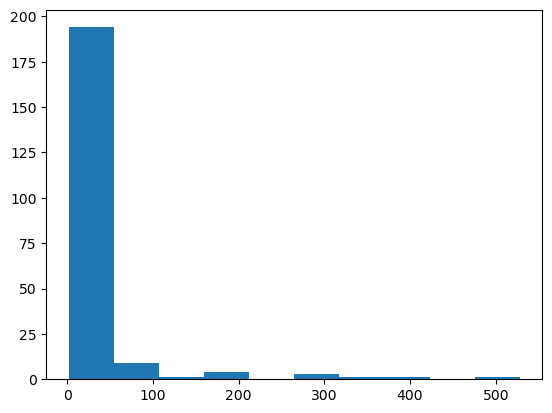

In [86]:
plt.hist([c for c in size_dist if c>1])

In [85]:
[c for c in size_dist if c>2]

[106,
 192,
 50,
 64,
 528,
 6,
 161,
 146,
 3,
 3,
 11,
 42,
 75,
 38,
 7,
 8,
 7,
 51,
 95,
 8,
 8,
 17,
 52,
 30,
 333,
 288,
 97,
 60,
 170,
 99,
 92,
 4,
 317,
 3,
 10,
 398,
 5,
 11,
 94,
 295,
 3,
 163]